In [36]:
options(warn=-1)
library("DESeq2")
library("dplyr")
library("ggplot2")
library('hexbin')
library("pheatmap")
library("RColorBrewer")
library("PoiClaClu")
library("repr")
options(warn=0)

In [37]:
countsfile <- 'Desktop/example_matrix.txt'
conditionsfile <- 'Desktop/example_conditions.txt'

In [38]:
countmatrix <- read.table(countsfile, sep="\t", header=TRUE)
coldata <- read.table(conditionsfile, sep="\t", header=TRUE)

In [39]:
dds = DESeqDataSetFromMatrix(countData = countmatrix, colData = coldata, design = ~ condition)
vsd <- vst(dds, blind = FALSE)
rld <- rlog(dds, blind = FALSE)

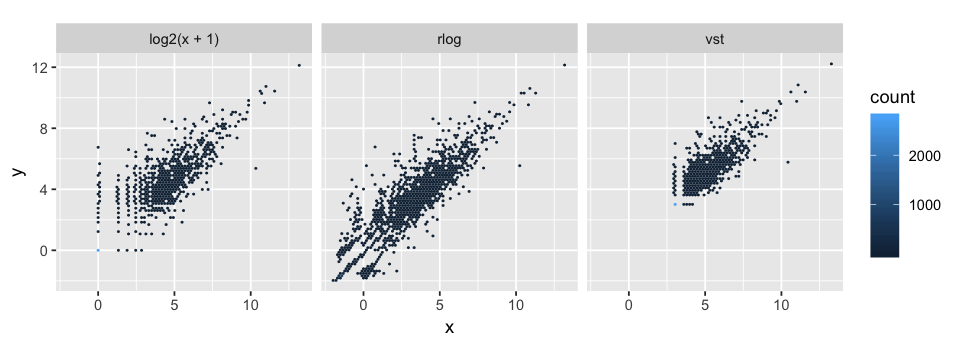

In [40]:
options(repr.plot.width=8, repr.plot.height=3)

dds <- estimateSizeFactors(dds)
df <- bind_rows(as_data_frame(log2(counts(dds, normalized=TRUE)[, 1:2]+1)) %>% mutate(transformation = "log2(x + 1)"), as_tibble(assay(vsd)[, 1:2]) %>% mutate(transformation = "vst"), as_tibble(assay(rld)[, 1:2]) %>% mutate(transformation = "rlog"))
colnames(df)[1:2] <- c("x", "y")  
ggplot(df, aes(x = x, y = y)) + geom_hex(bins = 80) + coord_fixed() + facet_grid( . ~ transformation)

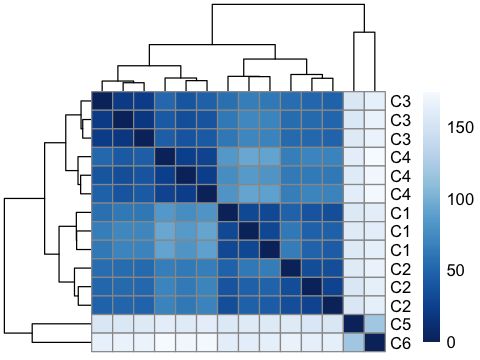

In [41]:
options(repr.plot.width=4, repr.plot.height=3)

sampleDists <- dist(t(assay(vsd)))
sampleDistMatrix <- as.matrix( sampleDists )
rownames(sampleDistMatrix) <- paste( vsd$condition )
colnames(sampleDistMatrix) <- NULL
colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)
pheatmap(sampleDistMatrix, clustering_distance_rows = sampleDists, clustering_distance_cols = sampleDists, col = colors)

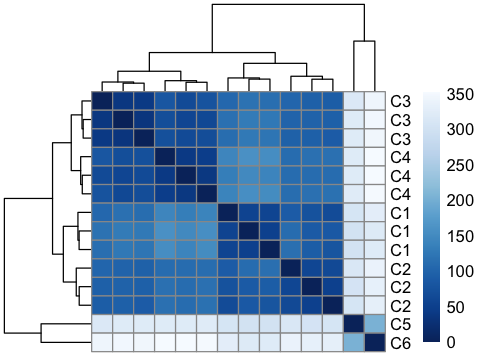

In [42]:
options(repr.plot.width=4, repr.plot.height=3)

sampleDists <- dist(t(assay(rld)))
sampleDistMatrix <- as.matrix( sampleDists )
rownames(sampleDistMatrix) <- paste( rld$condition )
colnames(sampleDistMatrix) <- NULL
colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)
pheatmap(sampleDistMatrix, clustering_distance_rows = sampleDists, clustering_distance_cols = sampleDists, col = colors)


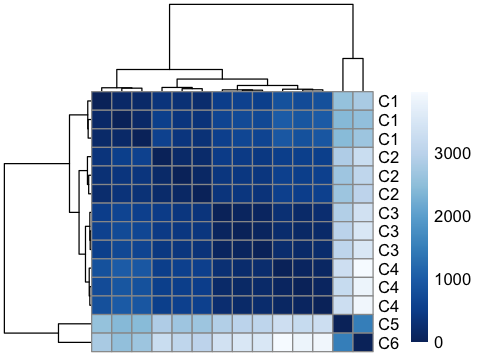

In [43]:
options(repr.plot.width=4, repr.plot.height=3)

poisd <- PoissonDistance(t(counts(dds)))
samplePoisDistMatrix <- as.matrix( poisd$dd )
rownames(samplePoisDistMatrix) <- paste( dds$condition )
colnames(samplePoisDistMatrix) <- NULL
pheatmap(samplePoisDistMatrix, clustering_distance_rows = poisd$dd, clustering_distance_cols = poisd$dd, col = colors)


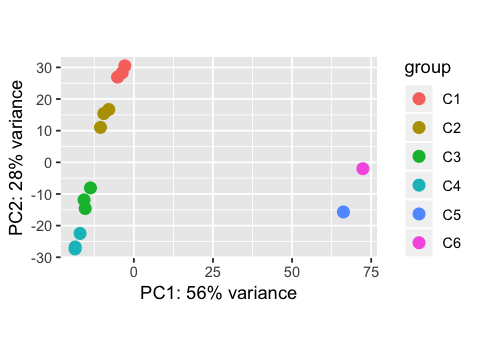

In [44]:
options(repr.plot.width=4, repr.plot.height=3)

plotPCA(vsd, intgroup = c("condition"))

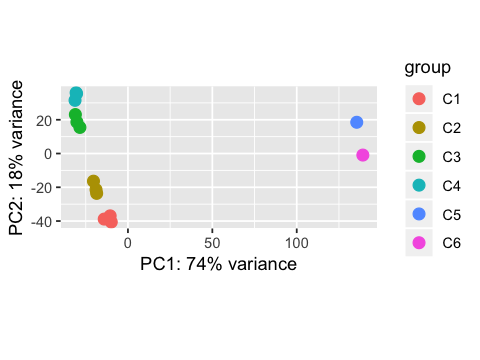

In [45]:
options(repr.plot.width=4, repr.plot.height=3)

plotPCA(rld, intgroup = c("condition"))